# Drug-Drug Similarity Using Text Mining Techniques


                                                                                by Alberto Olivares Alarcos

This notebook is part of the code developed into a Master Thesis and it is devoted to give a flavour of how to obtain a measurement of similarity between pairs of drugs by means of text mining techniques. As said before, this code is part of a Master Thesis, so we are not going to spend too much time explaining theoretical aspects. Please, if you have further interest in the project (e.g. knowing about the decision making), contact the author by e-mail: ***alberto.olivares.alarcos@gmail.com***.

## Background
Text similarity is the task of determining the degree of similarity between two texts. Texts length can vary from single words to paragraphs to complete novels or even books. In our case, the texts are a concatenation of different textual fields extracted from the DrugBank database. Since the way of computing the text-based similarity lies on the bag of words (BoW) paradigm, simple concatenation of textual fields seems to be a good choice (we do not care about the order of the words, just if they appear or not). Single words constitute a special case of text similarity which is commonly referred to as the task of computing word similarity and is not the focus of this project. 

The computation of text similarity is a very difficult task for machines. This is mainly due to the enormous variability in natural language, in which texts can be constructed using different lexical and syntactic constructions. Even so, computing text similarity has been for several years a fundamental means for many NLP tasks and applications. Nowadays, still a lot of works are devoted to this topic.

Our aim is to find a measure of similarity (or dissimilarity) among the drugs found in DrugBank by means of text similarity. To this purpose, the drugs were represented in a vector space model, which is an algebraic model for representing text documents and, thus, similarities can be computed in this space. To obtain the vector space model representation of the drugs, the data fields: description, indication and pharmacodynamics –all expressed in natural language– were concatenated and, after removing stop words and transforming to lowercase, their term frequency-inverse document frequency (tf-idf ) representation was computed. In this case, each document used to compute the tf-idf is the concatenation of the textual fields of each drug, while the corpus is formed by all those documents as a whole.
Thus, the the data is represented as the matrix $M  \epsilon  \mathbb{R}^{nxp}$, where $n$ is the number of drugs and $p$ the number of words in the whole corpus.

Usually, the number of terms within a corpus is large, this together with the fact that only few terms appear in a specific document give room to a sparse matrix. The high dimensionality and sparseness of the matrix M entail to a well-known phenomenon called 'curse of dimensionality'. In a nutshell, we lose statistical significance and the Euclidean distance becomes meaningless.

Reducing the dimension of the vector space model we have computed is the solution proposed in this work. Specifically, we use the technique that in Information Retrieval is known as Latent Semantic Indexing (LSI), for us, Latent Semantic Analysis (LSA).
LSA uses Singular Value Decomposition (SVD) to find the most discriminative features of our data vectors. As a result, we obtain a representation of our data in a reduced dimensional space in return for losing part of the information. The similarity matrix is computed using the Euclidean distance over the dimensionally reduced data.

## Evaluation

There are two main sorts of evaluation: direct and indirect. On the one hand, a direct evaluation is the one performed directly over the result you want to study. On the other hand, an indirect evaluation is the one in which you use the obtained result to solve a task and then you evaluate the performance of it over the task. Normally, the ideal evaluation is a direct one, in which the result is compared with a *'golden standard'*. However,it is difficult to evaluate our work since there is not any clear *'golden standard'* to compare our results with. 

In this project, we have performed two different evaluations over the computed similarities:


- **Clustering.** This is an example of indirect evaluation. We have used the similarities to cluster the drugs into groups. Then, we study the ATC Code distribution of those clusters in order to check if our similarity measurements are good. The reason why we use the ATC Code to evaluate is because we have cluster into 14 clusters (the same number of categories of the first level of ATC Code). We did not want to add much theory in this notebook, for that, ask for the Master Thesis documentation to the author. 

- **Ground Truth.** This evaluation is a small direct evaluation we have done with a ground truth annotated by experts in the domain. The similarity of a list of 100 pairs of drugs were annotated by 143 experts. We have taken it from a paper named: *'The use of 2D fingerprint methods to support the assessment of structural similarity in orphan drug legislation'*. Authors provide a file with this information in the webpage of the journey$^{[1]}$. and modified and adapted to our convenience. We compare the similarity computed for us with the similarity following the experts's opinion. 

|1] https://link.springer.com/article/10.1186/1758-2946-6-5

# IMPLEMENTATION

In [1]:
# Headers 
from sklearn.preprocessing import Normalizer, normalize, scale 
from sklearn.pipeline import make_pipeline 
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering 
import matplotlib.pyplot as plt
from operator import itemgetter
from IPython.display import Image
import numpy
import os
import sys
import csv

HERE = os.path.abspath(os.path.dirname("__file__"))
sys.path.append(os.path.join(HERE, ".."))

from utils.drugbank_accessor_ET import *
from utils.general_utils import *
from utils.evaluation_utils import *

print("Done")

Done


In [2]:
# Global varialbles
n_comp_list = [100, 200, 500] # Dimensions used to reduce the dimension of our vector space.

## DISTANCE/SIMILARITY MATRIX COMPUTATION

In [3]:
# Reading the corpus and creating a dictionary of drugs. 
zip_filepath = './../corpus/drugbank.xml_release_2017_12_20.zip' # Version 5.0.11
filename = 'drugbank.xml'

file = read_zip_file(zip_filepath, filename)
drugs = map_drugbank_from_file(file)
print(len(drugs))

1661


In [4]:
# Processing data and checking all instances have the fields we are interested in. 
ids = sorted(drugs.keys())
ids_dic = dict(enumerate(ids))
total_cases = len(ids)
print("Total cases ", total_cases)

attribute = ['description', 'indication', 'pharmacodynamics']

variable =  drug_term_dictionary(drugs, ids_dic, attr=attribute) # list of all the concatenated att for each drug

Total cases  1661
0  drugs found with empty fields


In [5]:
# Sparse matrix from the data by performing 'term frequency–inverse document frequency' (tf-idf) 
tfidf_variable = TfidfVectorizer(tokenizer=tokenize, stop_words='english',
                                 ngram_range=(1,1))
tfs_variable = tfidf_variable.fit_transform(variable)

In [6]:
# Dimensionality reduction (too much sparseness in our data matrix) 
print("tf-idf matrix dim: ", tfs_variable.A.shape)
tfs_scale = scale(tfs_variable.A, axis=0, with_std=False)
print("Num vars: ", len(np.mean(tfs_scale, axis=0)))
print('Total variance: ', np.var(tfs_variable.A,axis=0).sum())



tfs_red = []
for n_comp in n_comp_list: 
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    tfs_red.append(lsa.fit_transform(tfs_scale))

tf-idf matrix dim:  (1661, 14434)
Num vars:  14434
Total variance:  0.9772388585304425


In [7]:
# Distance matrix and saving data (if they do not already exist)
if not(os.path.exists('./../data/text_mining/dist_matrix.npy')):
    dist = squareform(pdist(tfs_scale, 'euclidean'))
    numpy.save('./../data/text_mining/dist_matrix.npy',dist)

for i in range (0, len(n_comp_list)):
    if not(os.path.exists('./../data/text_mining/dist_matrix_reduced'+str(n_comp_list[i])+'c.npy')):
        dist_red = squareform(pdist(tfs_red[i], 'euclidean'))
        numpy.save('./../data/text_mining/dist_matrix_reduced'+str(n_comp_list[i])+'c.npy',dist_red)

## EVALUATION

Just as a reminder, we have computed the distance matrix for different cases (with and without dimension reduction). We now have to read one of them and compute the similarity matrix to evaluate it. Two different evaluations are performed: one indirected (clustering) and another one directed (ground truth). Please, we here just show the code and the result, for the analysis of the result, read the Master Thesis, the author can send it to you.

### EVALUATION: CLUSTERING

In this case, we are using just one of the distance matrices, the one in which we have computed LSA with the number of components equal to 100. The reason is because it has shown the best results in the second evaluation. **NOTE... If you want to save the images of the histograms of the clusters distribution, modify the variable 'save_histograms' to True. Take into account that you will overwrite the previous images. You can also display or not the histograms and similarity matrices which are already on the folder of plots if you put the variable 'display_plots' to True.**

In [25]:
# Variables definition
ids = sorted(drugs.keys())
ids_dic = dict(enumerate(ids))

save_histograms = False
display_plots = True

ncomp = '100'
dist = numpy.load('./../data/text_mining/dist_matrix.npy')
dist_red = numpy.load('./../data/text_mining/dist_matrix_reduced'+ncomp+'c.npy')

In [9]:
# We need to normalize the distance matrix and then compute the similarity matrix 
norm_matrix = normalize_matrix(dist)
sim_matrix = bidirectional_conversion_between_distance_and_similarity_matrix(norm_matrix)

norm_matrix_red = normalize_matrix(dist_red)
sim_matrix_red = bidirectional_conversion_between_distance_and_similarity_matrix(norm_matrix_red)

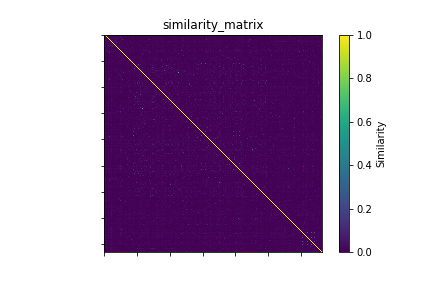

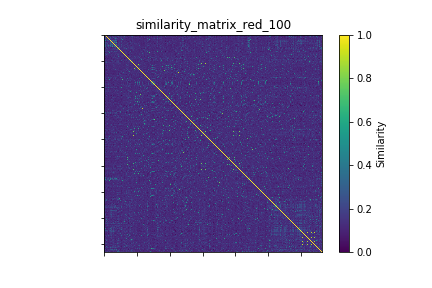

In [28]:
# Visual evaluation of Similarity
path_images = './../plots/text_mining/'

if not(os.path.exists('./../plots/text_mining/similarity_matrix.png')):
    save_similarity_matrix(numpy.array(sim_matrix), path_images, \
                       'similarity_matrix')
else: 
    if display_plots:
        img = Image(filename = path_images + "similarity_matrix.png", width=500, height=500)
        display(img)
    
if not(os.path.exists('./../plots/text_mining/similarity_matrix_red_'+ncomp+'.png')):
    save_similarity_matrix(numpy.array(sim_matrix_red), path_images, \
                       'similarity_matrix_red_'+ncomp)
else: 
    if display_plots:
        img = Image(filename = path_images + 'similarity_matrix_red_'+ncomp+'.png', width=500, height=500)
        display(img)

Total ATC:  3007


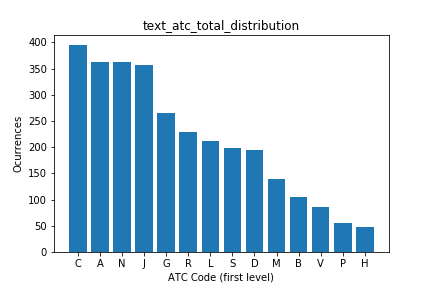

In [15]:
# Distribution of ATC Codes first level of the total set of used drugs (in order to understand better
# the result of our clustering).
atc_first_level_all_drugs = list()
for db_id in ids:
    atc_codes_dbid = getattr(drugs[db_id], 'atc_codes')
    for atc_code in atc_codes_dbid:
        atc_first_level_all_drugs.append(atc_code[0])

print('Total ATC: ', len(atc_first_level_all_drugs))

path_images = './../plots/evaluation/clustering/text_mining/'

if not (os.path.exists('./../plots/evaluation/clustering/text_mining/text_atc_total_distribution.png')):
    save_histogram(atc_first_level_all_drugs, path_images, \
                       'text_atc_total_distribution')
else: 
    img = Image(filename = path_images + 'text_atc_total_distribution.png', width=500, height=500)
    display(img)
    

In [16]:
# Spectral Clustering
sca = SpectralClustering(affinity="precomputed", n_clusters=14)
sca.fit(sim_matrix_red)
nclust = max(sca.labels_)+1

/usr/lib/python3/dist-packages/scipy/sparse/csgraph/_laplacian.py:71: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


In [13]:
# Building a container of the clusters with the DrugBank ids
clusters_idx = label_idx(sca.labels_, nclust)

clusters_dbid = dict()
for l in clusters_idx.keys():
     clusters_dbid[l] = idx_to_id(clusters_idx[l], ids_dic)

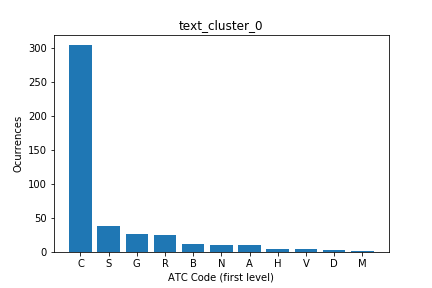

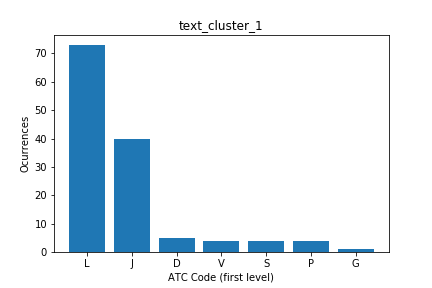

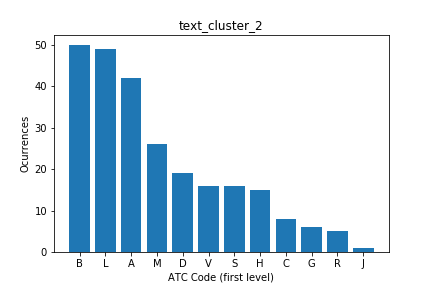

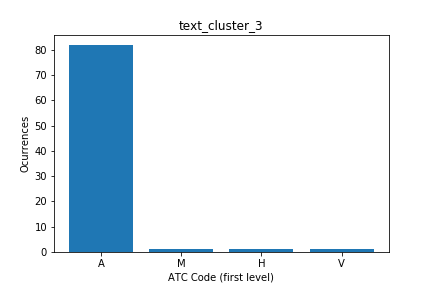

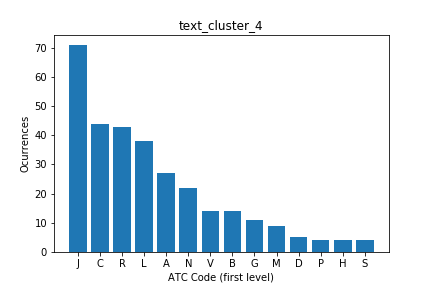

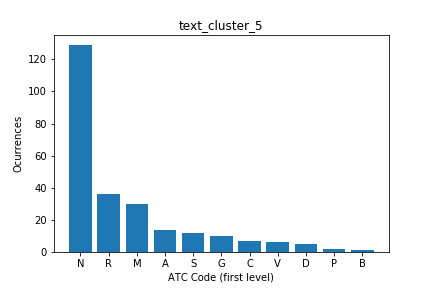

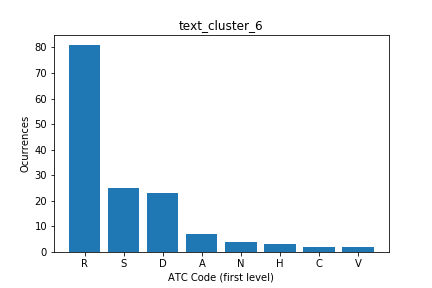

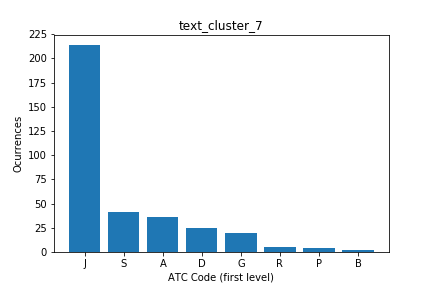

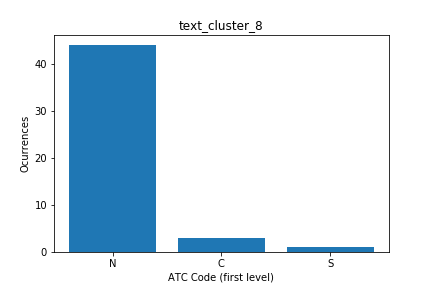

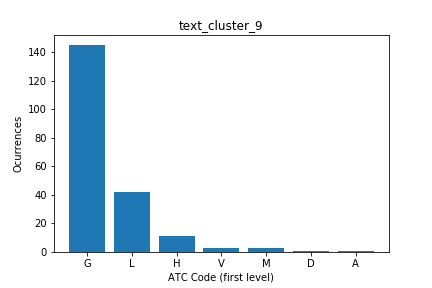

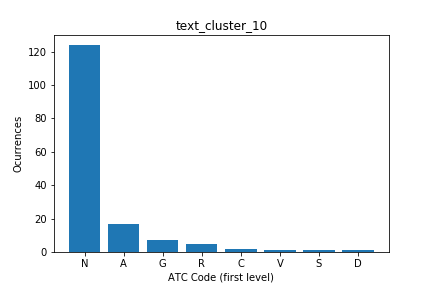

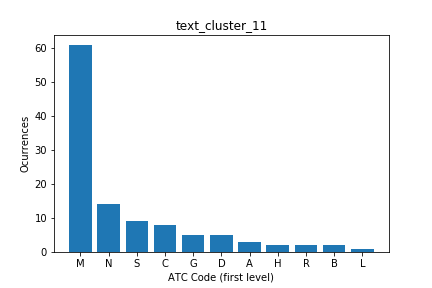

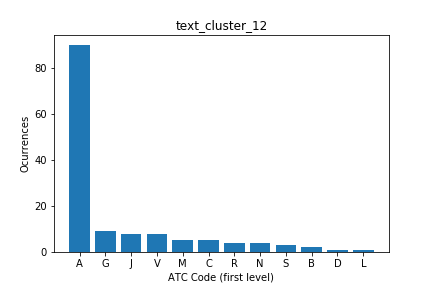

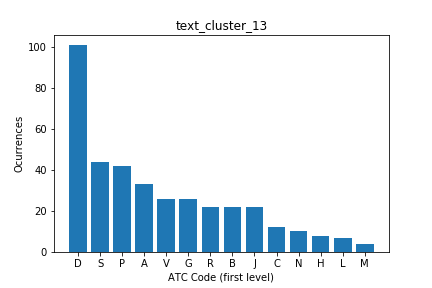

In [26]:
clusters_ATC_distribution = dict()
for cluster, drugbank_ids in clusters_dbid.items():
    atc_first_level_for_one_cluster = list()
    for db_id in drugbank_ids:
        atc_codes_dbid = getattr(drugs[db_id], 'atc_codes')
        for atc_code in atc_codes_dbid:
            atc_first_level_for_one_cluster.append(atc_code[0])
    clusters_ATC_distribution[cluster] = atc_first_level_for_one_cluster
    
path_images = './../plots/evaluation/clustering/text_mining/'

for i in range (0, len(clusters_ATC_distribution)):
    if not (os.path.exists('./../plots/evaluation/clustering/text_mining/text_cluster_'+str(i)+'.png')\
           or save_histograms):
        save_histogram(clusters_ATC_distribution[i], path_images, \
                           'text_cluster_'+str(i))
    else:
        if display_plots:
            img = Image(filename = path_images + 'text_cluster_'+str(i)+'.png', width=500, height=500)
            display(img)

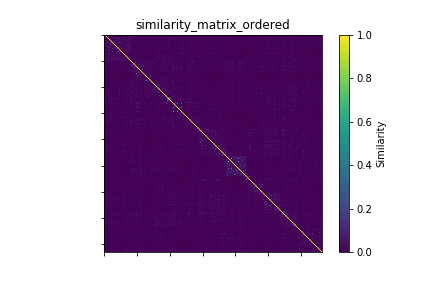

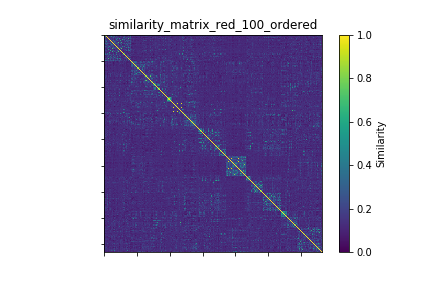

In [27]:
# Order the similarity matrices according to clusters
path_images = './../plots/text_mining/'

clusters_idx_ordered = list()
for i in range(nclust):
    clusters_idx_ordered += clusters_idx[i]
    
if not (os.path.exists('./../plots/text_mining/similarity_matrix_ordered.png')):
    save_similarity_matrix_ordered(numpy.array(sim_matrix), clusters_idx_ordered, path_images, \
                       'similarity_matrix_ordered')
else: 
    if display_plots:
        img = Image(filename = path_images + "similarity_matrix_ordered.png", width=500, height=500)
        display(img)
    
if not (os.path.exists('./../plots/text_mining/similarity_matrix_red_'+ncomp+'_ordered.png')):
    save_similarity_matrix_ordered(numpy.array(sim_matrix_red), clusters_idx_ordered, path_images, \
                       'similarity_matrix_red_'+ncomp+'_ordered')
else: 
    if display_plots:
        img = Image(filename = path_images + 'similarity_matrix_red_'+ncomp+'_ordered.png', width=500, height=500)
        display(img)

### EVALUATION: GROUND TRUTH

In this case, we are use the similarity matrices for the three cases of LSA: 100, 200 and 500 components.

In [21]:
ids = sorted(drugs.keys())
ids_dic = dict(enumerate(ids))

for ncomp in n_comp_list:
    print("\n\n------> Number of components for LSA: ", ncomp)
    dist_red = numpy.load('./../data/text_mining/dist_matrix_reduced'+str(ncomp)+'c.npy')
    norm_matrix_red = normalize_matrix(dist_red)
    sim_matrix_red = bidirectional_conversion_between_distance_and_similarity_matrix(norm_matrix_red)
    
    # Extract similarity for a list of pairs from a Similarity Matrix
    ground_truth_path = '../data/evaluation/ground_truth.csv'
    with open(ground_truth_path, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        ground_truth_list = list(reader)

    # We add an id for each pair (in order to evaluate afterwards the order infered by the similarity values)
    for i in range(0, len(ground_truth_list)):
        ground_truth_list[i].append(i)

    computed_similarity_list = compute_similarity_between_pairs(ids, sim_matrix_red, ground_truth_list)
    
    # Count number of pairs which actually are within our matrix
    n = len(computed_similarity_list)
    counter = 0
    for i in range(0, n):
        if computed_similarity_list[i][2] == -1:
            counter += 1
            
    print("The total of pairs from the ground truth is: ", n)
    print("The number of pairs we have from the total is: ", n - counter) # number of drugs which actually are in our matrix of similarity..
    
    # Here we evaluate two different things, if the order infered by the similarity values is the same in the pairs
    # and the correlation among the values of similarities predicted.
    
    # Necessary to not contemplate pairs which are not among our computed similarities (for the order correlation)
    computed_similarity_list_match = list()
    ground_truth_list_match = list()
    for i in range(0, len(computed_similarity_list)):
        if not computed_similarity_list[i][2] == -1:
            computed_similarity_list_match.append(computed_similarity_list[i])
            ground_truth_list_match.append(ground_truth_list[i])
    
    ground_truth_list_ordered = sorted(ground_truth_list, key=itemgetter(2)) # From 0 to 1 (similarity)
    computed_similarity_list_ordered = sorted(computed_similarity_list_match, key=itemgetter(2))

    print("Correlation between the order infered..")
    corr_order = ground_truth_evaluation_order(computed_similarity_list_ordered, ground_truth_list_ordered)
    print(corr_order)


    print("\nCorrelation between the values of the similarity..")
    corr_order = ground_truth_evaluation_value(computed_similarity_list, ground_truth_list)
    print(corr_order)

    print("\nAccuracy and recall using a threshold to determine similarity..")
    acc_threshold, recall_threshold = ground_truth_evaluation_threshold(computed_similarity_list, ground_truth_list, 0.85)
    print(acc_threshold, recall_threshold)



------> Number of components for LSA:  100
The total of pairs from the ground truth is:  97
The number of pairs we have from the total is:  65
Correlation between the order infered..
KendalltauResult(correlation=0.23269230769230764, pvalue=0.006141855951162044)

Correlation between the values of the similarity..
(0.7920365359241847, 3.9349013034459115e-15)

Accuracy and recall using a threshold to determine similarity..
0.7384615384615385 0.05555555555555555


------> Number of components for LSA:  200
The total of pairs from the ground truth is:  97
The number of pairs we have from the total is:  65
Correlation between the order infered..
KendalltauResult(correlation=-0.026923076923076918, pvalue=0.751215101577817)

Correlation between the values of the similarity..
(0.7505812923880141, 6.076001079445984e-13)

Accuracy and recall using a threshold to determine similarity..
0.7384615384615385 0.05555555555555555


------> Number of components for LSA:  500
The total of pairs from the